# **Introduction**

This is **Explanatory Data Analysis** And **Modelling**  for the [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge#description) <br>
Applied **NLP** techniques to get more insights and patterns for products features. Suggesting prices for various products, where prices vary according to brand, season, and other factors

**Data Description**
****
- **price** : (**Target Variable**) : float variable, should be predicted.
- **brand** :  name : String Value, brand of each product.
- **category** :  name: String Value, Consists of **3 parts** Main Category and 2 other sub-c**ategories**(will be examined further).
- **item** :  condition id : int value, where id = 1 means product is in best Condition, greater value low condition.
- **item** :  description : String value, the description of product (the bulk in our problem).
- **name** :  : String value, the Name of the product.
- **shipping** :  : boolean value(dummy variable), `shipping = 1` means seller pay the shipping fees `shipping = 0` buyer who pay such fees.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import gc
import scipy
from wordcloud import WordCloud

## Text Cleaning
import string
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from collections import Counter, OrderedDict
## Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer


# dimensionality reduction
from sklearn.decomposition import PCA, TruncatedSVD

## Modelling
from sklearn.linear_model import Ridge

plt.style.use('ggplot')
%matplotlib inline

In [2]:
PATH = "./data/"

In [3]:
df_train = pd.read_csv(f'{PATH}train.tsv', sep='\t')
df_test = pd.read_csv(f'{PATH}test.tsv', sep='\t')

In [4]:
print(f"Train consists of {df_train.shape[0]:,} observations\nTest consists of {df_test.shape[0]:,} observations")

Train consists of 1,482,535 observations
Test consists of 693,359 observations


# Target Variable

### Price

In [5]:
df_train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [6]:
df_train['price'].isnull().sum()

0

In [7]:
print("There Exist {} items sold for Free!".format(df_train[df_train['price'] == 0].shape[0]))

There Exist 874 items sold for Free!


**Notes**
- some prices include zero values about (0.05%)
- mean price is around **26 £** while max  price is around **2009 £** ( which means a **skewness** in our variable )
- No null vaues (good)

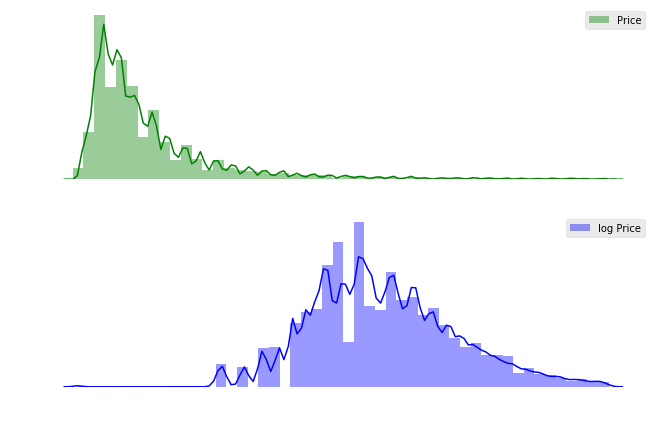

In [8]:
fig, ax = plt.subplots(2,figsize=(11,7))

sns.distplot( df_train[df_train['price'] <  df_train['price'].quantile(0.99)]['price'], ax=ax[0], 
             label='Price', color="green")

sns.distplot( np.log1p(df_train[df_train['price'] <  df_train['price'].quantile(0.99)]['price']), ax=ax[1],
             label="log Price", color="blue")

ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[0].set_title("")
ax[1].set_title("")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

Well, Price is **Right skewed** as been expected, which induce  **Log transformation**<br>
(we add 1 as some `price` values equal to `zero`)

In [9]:
nrow_train = df_train.shape[0]
y_train = np.log1p(df_train['price'])

### Data Cleaning

In [11]:
null_df = pd.DataFrame(df_train.dtypes).T.rename(index={0: 'dtype'})
null_df = null_df.append(pd.DataFrame(df_train.isnull().sum()).T.rename(index={0: 'count'}))
null_df = null_df.append(pd.DataFrame(df_train.isnull().sum() /df_train.shape[0] * 100 ).T.rename(index={0: '%'}))
null_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
dtype,int64,object,int64,object,object,float64,int64,object
count,0,0,0,6327,632682,0,0,4
%,0,0,0,0.426769,42.6757,0,0,0.000269808


Well,
`brand name` got about **43%** missing values, but it is not a big deal,<br> as it's not as important as the `item description` which fortunately got about **0%** null values <br><br>
Other null values is from the **concatenation** process, which is done to maintain the **data consistency** 

In [12]:
df_train['brand_name'] = df_train['brand_name'].fillna("Other")
df_train['item_description'] = df_train['item_description'].fillna("No description yet")
df_train['item_description'] = df_train['item_description'].astype(str)
df_train['shipping'] = df_train['shipping'].astype('category')
df_train['item_condition_id'] = df_train['item_condition_id'].astype('category')

df_test['brand_name'] = df_test['brand_name'].fillna("Other")
df_test['item_description'] = df_test['item_description'].fillna("No description yet")
df_test['item_description'] = df_test['item_description'].astype(str)
df_test['shipping'] = df_test['shipping'].astype('category')
df_test['item_condition_id'] = df_test['item_condition_id'].astype('category')

df_train['logprice'] = y_train



In [13]:
df_train.duplicated().sum()

0

We got no duplicates in our dataset

### Shipping

Determine whether seller payed the shipping fees, or the buyer who payed

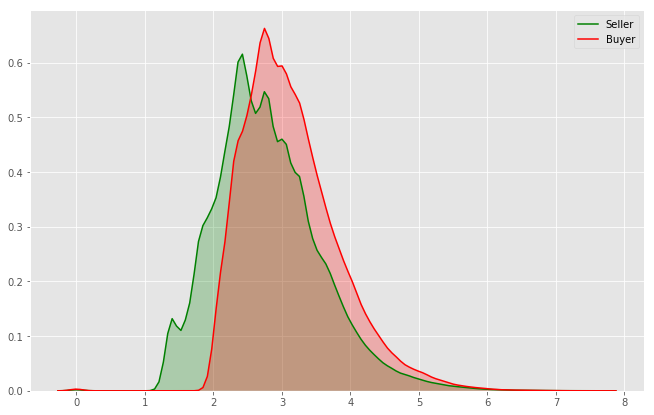

In [14]:
plt.figure(figsize=(11,7))

sns.kdeplot(df_train[df_train['shipping'] == 1].loc[:, 'logprice'], shade=True, color="g", bw=.09, label="Seller")

sns.kdeplot(df_train[df_train['shipping'] == 0].loc[:, 'logprice'], shade=True, color="r", bw=.09, label="Buyer")

plt.show()

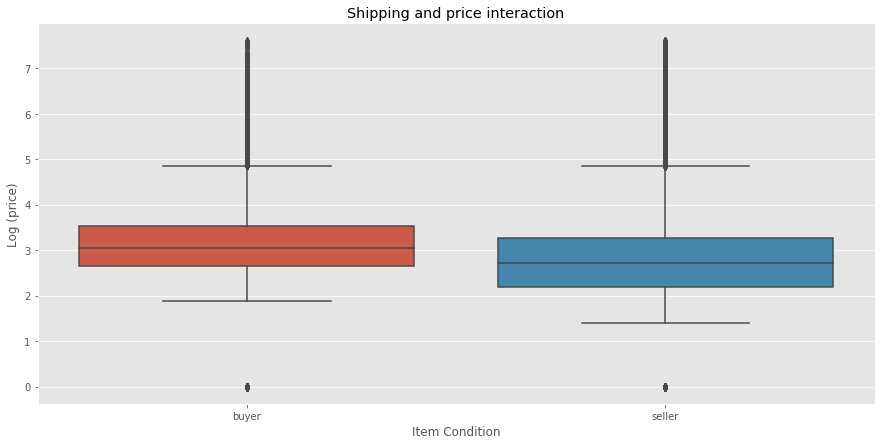

In [15]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='shipping', y='logprice', data=df_train)
ax.set_xticklabels(["buyer", "seller"])
plt.ylabel("Log (price)")
plt.xlabel("Item Condition")

plt.title("Shipping and price interaction")
plt.show()

So apparently items which `buyer` pay their **shipping fees**, are **more Expensive**

### Brand

In [16]:
brand_cat = df_train.groupby(by='brand_name').agg({'price':np.median})
brand_cat = pd.DataFrame(brand_cat).rename(columns={1:'price'}).reset_index()
brand_cat = brand_cat.sort_values('price', ascending=False)

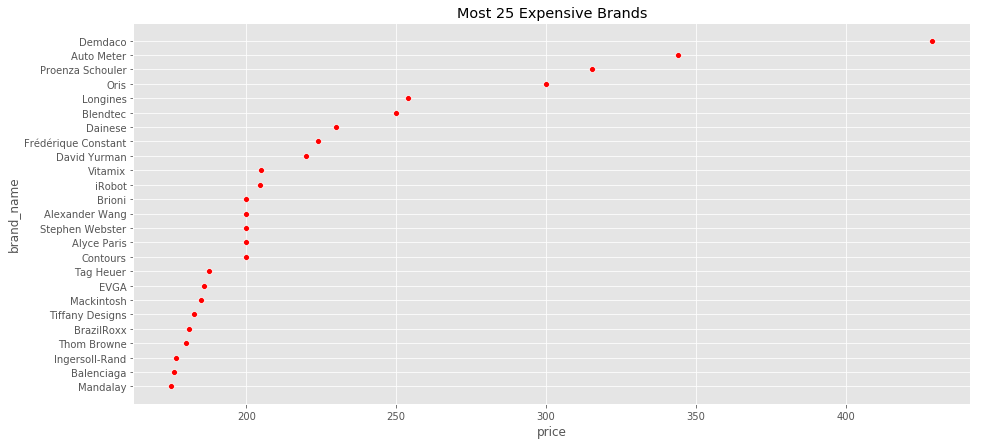

In [17]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x='price', y='brand_name', data=brand_cat[:25], color='r')
ax.invert_yaxis()
plt.title("Most 25 Expensive Brands")
plt.show()

In [18]:
len(brand_cat)

4810

In [19]:
d = dict()
for brand, pr in zip(brand_cat.brand_name[:200], brand_cat.price[:200]):
    d[brand] = pr

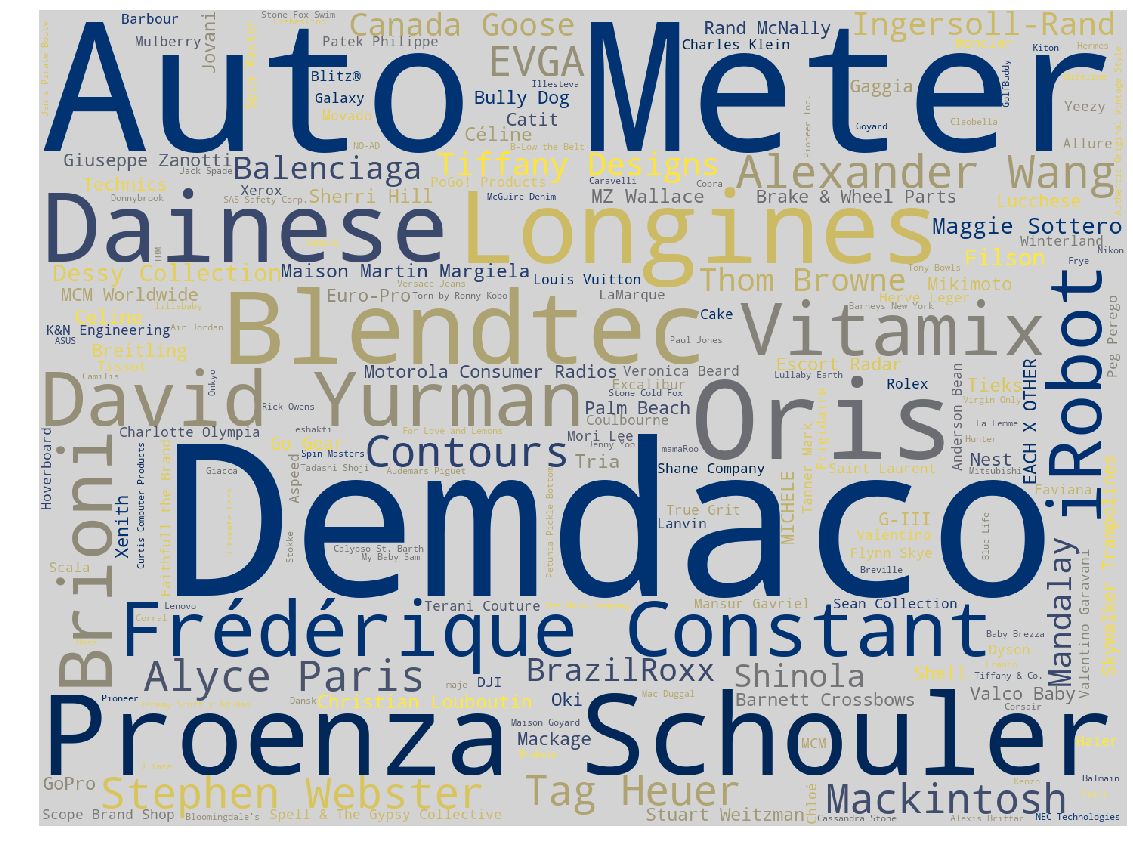

In [20]:
cloud = WordCloud(width=1440, height=1080, background_color='lightgrey', colormap='cividis', random_state=42).generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

So **Demdaco** is the most Expensive Brand with over **400 £** which could be treated as **Outlier** according to other brands. <br> May **`brand`** considered as an important feature to our model.

### item condition

items are ordered Feature, ranges from [1,5], where <br>**1 value** means item is in its **Best condition** and **5 value** is **Worst**

In [21]:
conditions = df_train['item_condition_id'].value_counts()

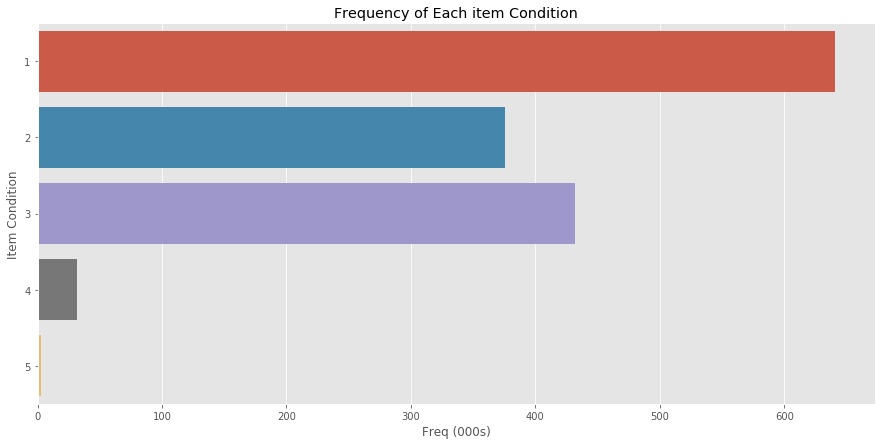

In [22]:
plt.figure(figsize=(15,7))
ax = sns.countplot(y = df_train['item_condition_id'])
ax.set_xticklabels([int(x/1000) for x in ax.get_xticks()])
plt.ylabel("Item Condition")
plt.xlabel("Freq (000s)")
plt.title("Frequency of Each item Condition")
plt.show()

Well, Items are more likely to be in **first (best) condition**, also **3rd Conditioned** are **more popular** than **2nd ones**

Now let's see how **`price` interaction** goes with **item condition**

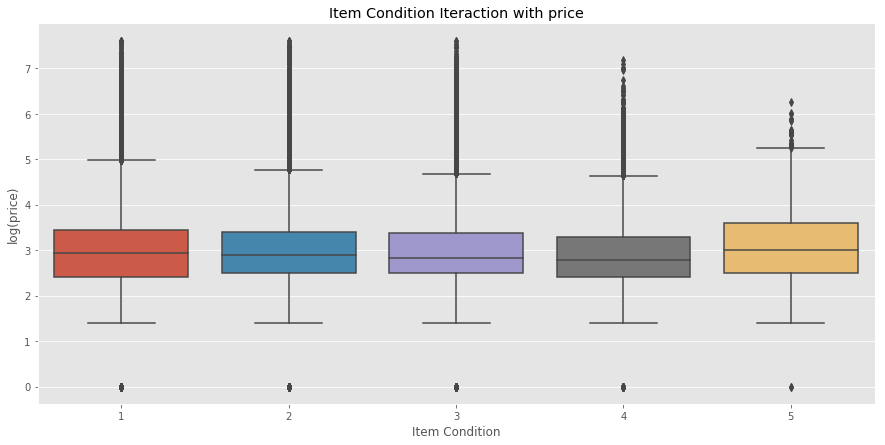

In [23]:
plt.figure(figsize=(15,7))
sns.boxplot(x='item_condition_id', y='logprice', data=df_train)
plt.ylabel("log(price)")
plt.xlabel("Item Condition")
plt.title("Item Condition Iteraction with price")
plt.show()

That's a little bit wierd... Worst Condtioned items got the highest value ....<br> After all, Price didn't vary much across Item Condition.

### Item Category

In [24]:
df_train.category_name.head()

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

Apparently, Category is splitted into 3 sub-categories, so let's split them

In [25]:
def split_categ(c):
        try:
            c1, c2, c3 = c.split("/")
            return c1, c2, c3
        except:
            return ("No label","No label","No label")

In [26]:
df_train['cat1'], df_train['cat2'], df_train['cat3']= zip(*df_train.category_name.apply(split_categ))
df_test['cat1'], df_test['cat2'], df_test['cat3']= zip(*df_test.category_name.apply(split_categ))

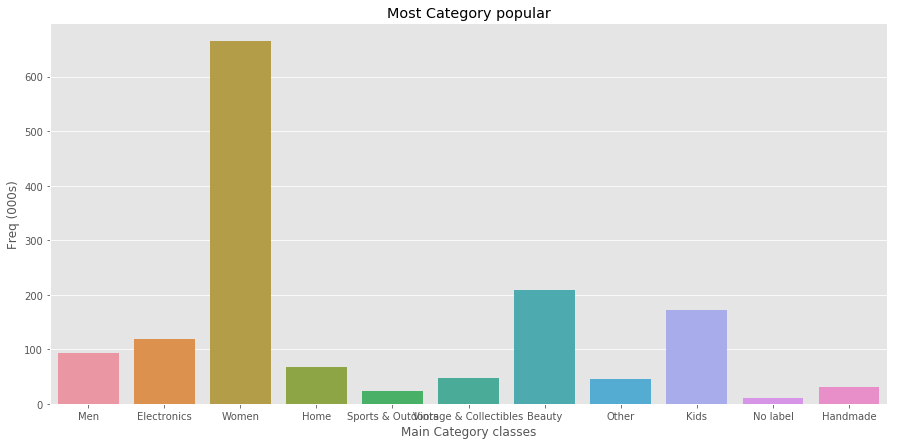

In [28]:
plt.figure(figsize=(15,7))
ax = sns.countplot(df_train.cat1)
ax.set_yticklabels([int(y/1000) for y in ax.get_yticks()])
plt.ylabel("Freq (000s)")
plt.xlabel("Main Category classes")
plt.title("Most Category popular")
plt.show()

**Women** are the most ones making shopping after all,

#### Main Category and price interaction

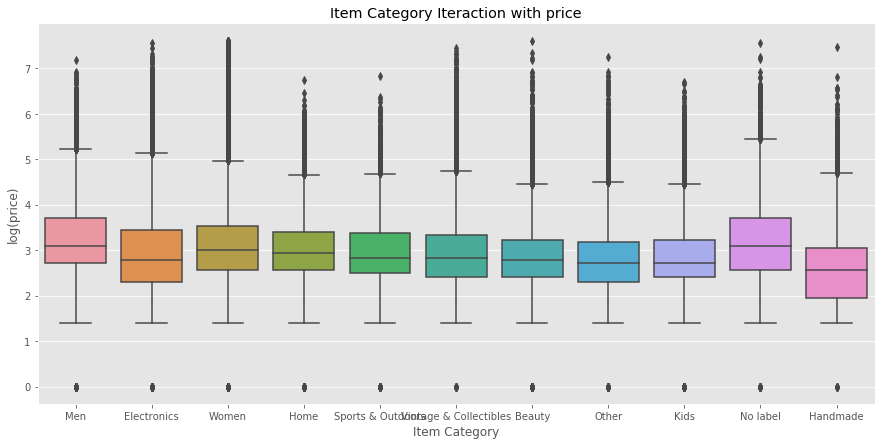

In [29]:
plt.figure(figsize=(15,7))
sns.boxplot(x='cat1', y='logprice', data=df_train)
plt.ylabel("log(price)")
plt.xlabel("Item Category")
plt.title("Item Category Iteraction with price")
plt.show()

And now men products are the most expensive ... maybe that's a one reason where men not interested in such place<br>
Anyway, Such **Feature** still **doesn't** give us the value we need for building the model, <br>**still no correlation with price**

In [30]:
cat2S = df_train.groupby('cat2')['cat2'].count()
cat2S = pd.DataFrame(cat2S).rename(columns={'cat2': 'freq'}).reset_index()
cat2S = cat2S.sort_values(by='freq', ascending=False)

In [31]:
len(cat2S)

114

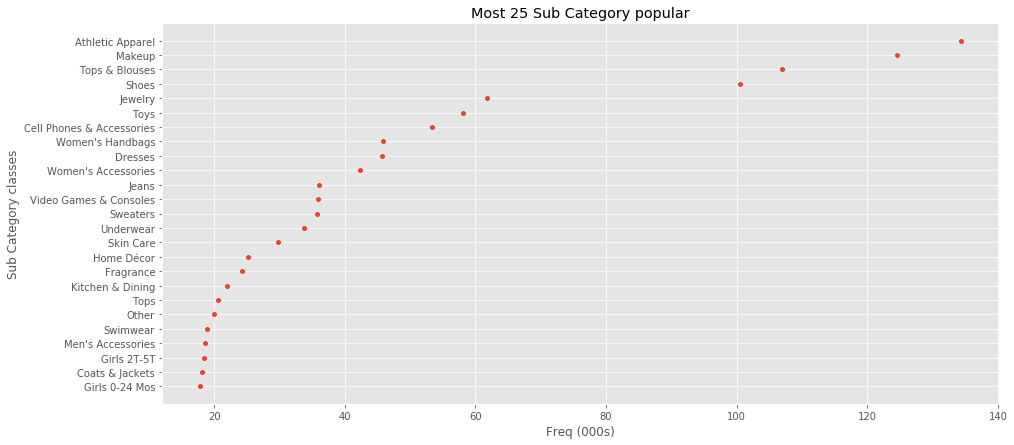

In [32]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(y='cat2', x='freq', data=cat2S.head(25))
ax.invert_yaxis()
ax.set_xticklabels([int(x/1000) for x in ax.get_xticks()])
plt.xlabel("Freq (000s)")
plt.ylabel("Sub Category classes")
plt.title("Most 25 Sub Category popular")
plt.show()

Also Women products are on the top of The second Sub category products

In [33]:
cat3S = df_train.groupby('cat3')['cat3'].count()
cat3S = pd.DataFrame(cat3S).rename(columns={'cat3': 'freq'}).reset_index()
cat3S = cat3S.sort_values(by='freq', ascending=False)

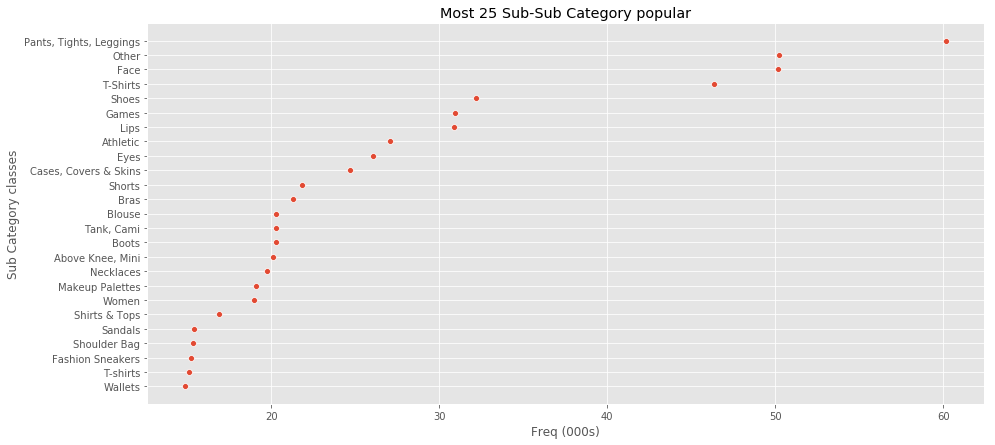

In [34]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(y='cat3', x='freq', data=cat3S.head(25))
ax.invert_yaxis()
ax.set_xticklabels([int(x/1000) for x in ax.get_xticks()])
plt.xlabel("Freq (000s)")
plt.ylabel("Sub Category classes")
plt.title("Most 25 Sub-Sub Category popular")
plt.show()

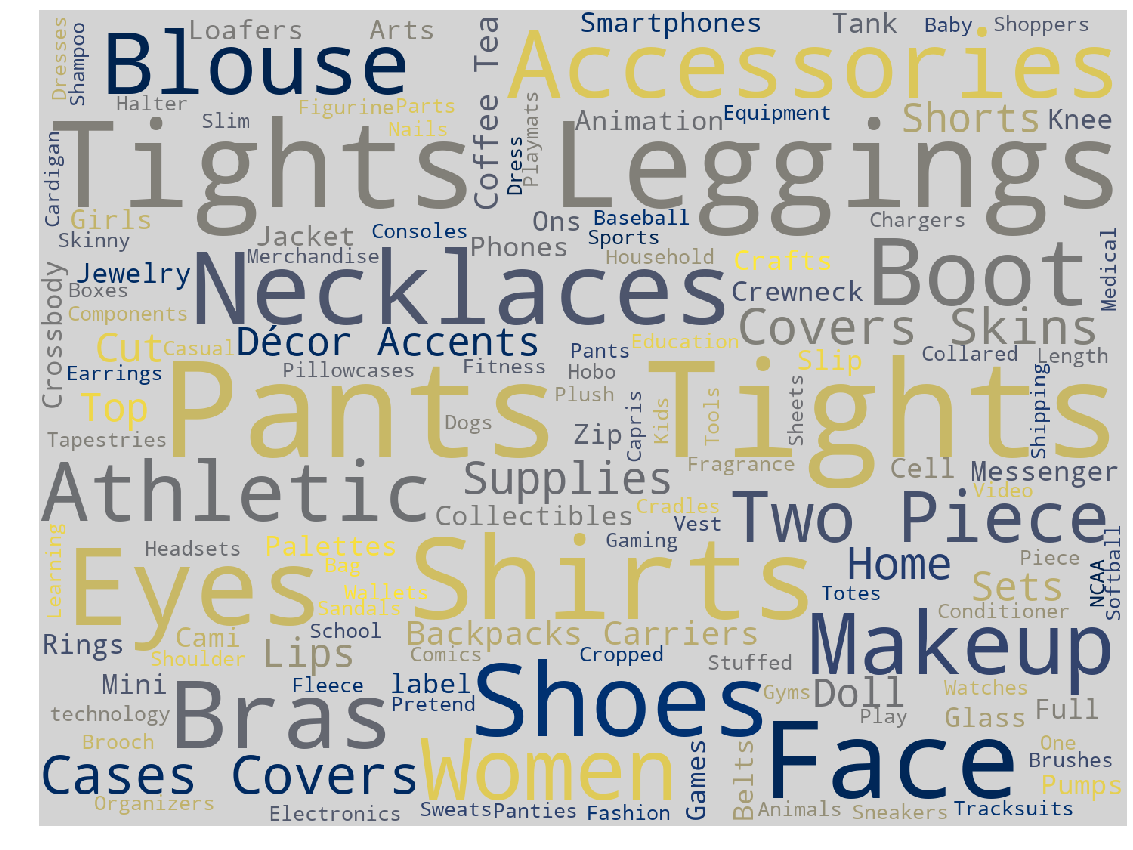

In [35]:
cloud = WordCloud(width=1440, height=1080, background_color='lightgrey', colormap='cividis', random_state=4).generate(" ".join(df_train['cat3'].astype(str)[:200]))

plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

### Tf-IDF

In [42]:
vectorizer = TfidfVectorizer(max_df=0.9, max_features=1_000, stop_words = "english")

In [43]:
X_desc_train = vectorizer.fit_transform(df_train['item_description'])
X_desc_test  = vectorizer.transform(df_test['item_description'])

In [44]:
print("We have {} keywords from our Description Corpus".format(len(vectorizer.get_feature_names())))

We have 1000 keywords from our Description Corpus


In [50]:
print("Tf-IDF Matrix shape {}, the Original matrix shape {:,}".format(X_desc_train.get_shape(), df_train.shape[0]))

Tf-IDF Matrix shape (1482535, 1000), the Original matrix shape 1,482,535


So for each docuemnt of the **2M** we got a vector of around **1000** dimension describing how important its keywords, and how these keywords are indicative to such document

###  Modeling

In [51]:
NUM_TOP_BRANDS = 2500
top_brands = df_train['brand_name'].value_counts().index[:NUM_TOP_BRANDS]
df_train.loc[~df_train['brand_name'].isin(top_brands), 'brand_name'] = "Other"

brand_lv = LabelBinarizer(sparse_output=True)
X_brand_train  = brand_lv.fit_transform(df_train['brand_name'])
X_brand_test   = brand_lv.transform(df_test['brand_name'])

In [52]:
X_brand_train.get_shape() , X_brand_test.get_shape() 

((1482535, 2500), (693359, 2500))

In [53]:
MIN_NAME_DF = 10
name_cv = CountVectorizer(min_df=MIN_NAME_DF)
X_name_train  = name_cv.fit_transform(df_train['name']) 
X_name_test   = name_cv.transform(df_test['name']) 

In [55]:
X_name_train.shape, X_name_test.shape

((1482535, 17740), (693359, 17740))

In [56]:
cat1_cv = CountVectorizer()
X_cat1_train  = cat1_cv.fit_transform(df_train['cat1'])
X_cat1_test   = cat1_cv.transform(df_test['cat1'])

In [57]:
X_cat1_train.shape, X_cat1_test.shape

((1482535, 14), (693359, 14))

In [58]:
cat2_cv = CountVectorizer()
X_cat2_train  = cat2_cv.fit_transform(df_train['cat2'])
X_cat2_test   = cat2_cv.transform(df_test['cat2'])

In [59]:
X_cat2_train.shape, X_cat2_test.shape

((1482535, 143), (693359, 143))

In [60]:
X_dummies_train = scipy.sparse.csr_matrix( pd.get_dummies(df_train[['shipping', 'item_condition_id']], sparse=True).values)
X_dummies_test  = scipy.sparse.csr_matrix( pd.get_dummies(df_test[['shipping', 'item_condition_id']], sparse=True).values)

In [61]:
X_dummies_train.shape, X_dummies_test.shape

((1482535, 7), (693359, 7))

In [62]:
X_train = scipy.sparse.hstack((
                        X_dummies_train,
                        X_desc_train,
                        X_name_train,
                        X_brand_train,
                        X_cat1_train,
                        X_cat2_train
                        )).tocsr()

X_test = scipy.sparse.hstack((
                        X_dummies_test,
                        X_desc_test,
                        X_name_test,
                        X_brand_test,
                        X_cat1_test,
                        X_cat2_test
                        )).tocsr()

In [63]:
X_train.shape, X_test.shape

((1482535, 21404), (693359, 21404))

In [64]:
model = Ridge(solver='lsqr', fit_intercept=False)
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [65]:
preds = model.predict(X_test)

In [66]:
df_test['price'] = np.expm1(preds)

In [67]:
df_test[['test_id', 'price']].to_csv('ridge_submission_v2.csv', index=False)